<a href="https://colab.research.google.com/github/vigneshvalliappan/MSAI_CV_Project/blob/main/Playground/flq_playground_gender_LR_exp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Nov 18 07:19:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import cv2
from matplotlib import pyplot as plt
import json

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from random import randint
import time

In [4]:
# decide whether to compute using GPU

device= torch.device("cuda")
#device= torch.device("cpu")
print(device)

cuda


In [5]:
fold_0 = pd.read_csv('/content/drive/MyDrive/MSAI CV/MSAI CV Project/Data/fold_0_data.txt',sep='\t')
fold_1 = pd.read_csv('/content/drive/MyDrive/MSAI CV/MSAI CV Project/Data/fold_1_data.txt',sep='\t')
fold_2 = pd.read_csv('/content/drive/MyDrive/MSAI CV/MSAI CV Project/Data/fold_2_data.txt',sep='\t')
fold_3 = pd.read_csv('/content/drive/MyDrive/MSAI CV/MSAI CV Project/Data/fold_3_data.txt',sep='\t')
fold_4 = pd.read_csv('/content/drive/MyDrive/MSAI CV/MSAI CV Project/Data/fold_4_data.txt',sep='\t')
df_combined = pd.concat([fold_0,fold_1,fold_2,fold_3,fold_4],ignore_index=True)
print(f'Number of rows: {len(df_combined)}')
df_combined.info()

Number of rows: 19370
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19370 entries, 0 to 19369
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   user_id             19370 non-null  object
 1   original_image      19370 non-null  object
 2   face_id             19370 non-null  int64 
 3   age                 19370 non-null  object
 4   gender              18591 non-null  object
 5   x                   19370 non-null  int64 
 6   y                   19370 non-null  int64 
 7   dx                  19370 non-null  int64 
 8   dy                  19370 non-null  int64 
 9   tilt_ang            19370 non-null  int64 
 10  fiducial_yaw_angle  19370 non-null  int64 
 11  fiducial_score      19370 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.8+ MB


In [6]:
df_combined.head()

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0,414,1086,1383,-115,30,17
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301,105,640,641,0,0,94
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,2395,876,771,771,175,-30,74
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,752,1255,484,485,180,0,47
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,175,80,769,768,-75,0,34


In [7]:
# new column to specify the file path
#df_combined['filepath'] = 'AdienceBenchmarkGenderAndAgeClassification/faces/' + df_combined['user_id'] + '/coarse_tilt_aligned_face.' + df_combined['face_id'].astype('str') + '.' + df_combined['original_image']
#df_combined['filepath']

df_combined['image_path'] = '/content/drive/MyDrive/MSAI CV/MSAI CV Project/Data/faces/' + df_combined['user_id'] + '/coarse_tilt_aligned_face.' + df_combined['face_id'].astype('str') + '.' + df_combined['original_image']
df_combined['image_path']

0        /content/drive/MyDrive/MSAI CV/MSAI CV Project...
1        /content/drive/MyDrive/MSAI CV/MSAI CV Project...
2        /content/drive/MyDrive/MSAI CV/MSAI CV Project...
3        /content/drive/MyDrive/MSAI CV/MSAI CV Project...
4        /content/drive/MyDrive/MSAI CV/MSAI CV Project...
                               ...                        
19365    /content/drive/MyDrive/MSAI CV/MSAI CV Project...
19366    /content/drive/MyDrive/MSAI CV/MSAI CV Project...
19367    /content/drive/MyDrive/MSAI CV/MSAI CV Project...
19368    /content/drive/MyDrive/MSAI CV/MSAI CV Project...
19369    /content/drive/MyDrive/MSAI CV/MSAI CV Project...
Name: image_path, Length: 19370, dtype: object

# Gender Model

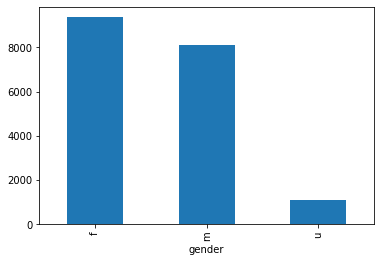

In [8]:
# gender break down
df_combined.groupby(['gender'])['gender'].count().plot.bar()

In [9]:
# filtered of unlabelled data
print(f'Total Number of records: {len(df_combined)}')
df_gender = df_combined.copy()
df_gender = df_gender[df_gender['gender'] != 'u']
df_gender = df_gender[df_gender['gender'].notna()]
print(f'Total Number of records with Gender Labels: {len(df_gender)}')

# gender class
print('Gender Class (before labelling): ')
print(df_gender.gender.value_counts())

# convert class to int
def labelling_gender(gender_range):
    if gender_range == 'm':
        result = 0
    elif gender_range == 'f':
        result = 1
    else:
        print(gender_range)
    return result

df_gender['label_gender'] = df_gender['gender'].apply(labelling_gender)
print('Gender Class (after labelling): ')
print(df_gender.label_gender.value_counts())

df_gender.reset_index(inplace=True)
df_gender.drop(columns=['index'],inplace=True)
df_gender

Total Number of records: 19370
Total Number of records with Gender Labels: 17492
Gender Class (before labelling): 
f    9372
m    8120
Name: gender, dtype: int64
Gender Class (after labelling): 
1    9372
0    8120
Name: label_gender, dtype: int64


,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score,image_path,label_gender
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0,414,1086,1383,-115,30,17,/content/drive/MyDrive/MSAI CV/MSAI CV Project...,1
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301,105,640,641,0,0,94,/content/drive/MyDrive/MSAI CV/MSAI CV Project...,0
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,2395,876,771,771,175,-30,74,/content/drive/MyDrive/MSAI CV/MSAI CV Project...,1
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,752,1255,484,485,180,0,47,/content/drive/MyDrive/MSAI CV/MSAI CV Project...,0
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,175,80,769,768,-75,0,34,/content/drive/MyDrive/MSAI CV/MSAI CV Project...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17487,101515718@N03,10587826073_6663f5b654_o.jpg,2280,"(25, 32)",f,718,748,492,492,0,0,63,/content/drive/MyDrive/MSAI CV/MSAI CV Project...,1
17488,101515718@N03,10587571495_a61785cd06_o.jpg,2278,"(25, 32)",m,48,472,768,768,-15,0,25,/content/drive/MyDrive/MSAI CV/MSAI CV Project...,0
17489,101515718@N03,10587571495_a61785cd06_o.jpg,2279,"(25, 32)",f,950,0,692,687,-5,0,27,/content/drive/MyDrive/MSAI CV/MSAI CV Project...,1
17490,50458575@N08,9426695459_9e8b347604_o.jpg,2281,"(25, 32)",f,831,895,899,899,0,15,59,/content/drive/MyDrive/MSAI CV/MSAI CV Project...,1


In [10]:
from torchvision.io import read_image
from torch.utils.data import Dataset
from skimage import io
from PIL import Image

class FaceDataset(Dataset):
    #def __init__(self, csv_file, model='gender', transform=None):
    def __init__(self, df, model='gender', transform=None):
        #self.df = pd.read_csv(csv_file)
        self.df = df
        self.model = model
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self,idx):
        img_path = self.df['image_path'][idx]
        image = Image.open(img_path)
        if self.model == 'gender':
            label = self.df['label_gender'][idx]
        elif self.model == 'age':
            label = self.df['label_age'][idx]
        else:
            print('Please specify "gender" or "age".')
            label = None
        if self.transform:
            image = self.transform(image)
        return (image, label)

In [11]:
transform = transforms.Compose(
    [
        transforms.Resize((128,128)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ]
)

In [12]:
df_gender.to_csv('/content/drive/MyDrive/MSAI CV/MSAI CV Project/df_gender.csv')

In [13]:
#dataset_gender = FaceDataset(csv_file='/content/drive/MyDrive/MSAI CV/MSAI CV Project/df_gender.csv',model='gender',transform=transform)
dataset_gender = FaceDataset(df=df_gender,model='gender',transform=transform)
dataset_gender_len = len(dataset_gender)
print(dataset_gender_len)
print([int(dataset_gender_len*0.7),dataset_gender_len - int(len(dataset_gender)*0.7)])
train_gender, test_gender = torch.utils.data.random_split(dataset_gender,[int(dataset_gender_len*0.7),dataset_gender_len - int(len(dataset_gender)*0.7)])

from torch.utils.data import DataLoader

train_gender_loader = DataLoader(train_gender,batch_size=20,shuffle=True)
test_gender_loader = DataLoader(test_gender,batch_size=20,shuffle=True)

17492
[12244, 5248]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([20, 3, 128, 128])
Labels batch shape: torch.Size([20])


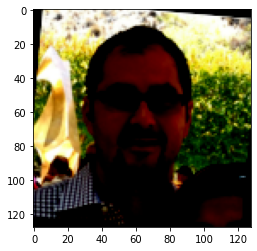

In [14]:
train_features, train_labels = next(iter(train_gender_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
plt.imshow(img.permute(1, 2, 0))

In [15]:
class model_gender(nn.Module): # VGG_convnet

    def __init__(self):
        super(model_gender,self).__init__()

        # block 1:         3 x 128 x 128 --> 64 x 32 x 32        
        self.conv1a = nn.Conv2d(3,   64,  kernel_size=3, padding=1 )
        self.conv1b = nn.Conv2d(64,  64,  kernel_size=3, padding=1 )
        self.pool1  = nn.MaxPool2d(4,4)

        # block 2:         64 x 32 x 32 --> 128 x 8 x 8
        self.conv2a = nn.Conv2d(64,  128, kernel_size=3, padding=1 )
        self.conv2b = nn.Conv2d(128, 128, kernel_size=3, padding=1 )
        self.pool2  = nn.MaxPool2d(4,4)

        # block 3:         128 x 8 x 8 --> 256 x 4 x 4        
        self.conv3a = nn.Conv2d(128, 256, kernel_size=3, padding=1 )
        self.conv3b = nn.Conv2d(256, 256, kernel_size=3, padding=1 )
        self.pool3  = nn.MaxPool2d(2,2)

        #block 4:          256 x 4 x 4 --> 512 x 2 x 2
        self.conv4a = nn.Conv2d(256, 512, kernel_size=3, padding=1 )
        self.pool4  = nn.MaxPool2d(2,2)

        # linear layers:   512 x 2 x 2 --> 2048 --> 4096 --> 4096 --> 10
        self.linear1 = nn.Linear(2048, 4096)
        self.linear2 = nn.Linear(4096, 4096)
        self.linear3 = nn.Linear(4096, 2)
        
    def forward(self, x):

        # block 1:         3 x 32 x 32 --> 64 x 16 x 16
        x = self.conv1a(x)
        x = F.relu(x)
        x = self.conv1b(x)
        x = F.relu(x)
        x = self.pool1(x)

        # block 2:         64 x 16 x 16 --> 128 x 8 x 8
        x = self.conv2a(x)
        x = F.relu(x)
        x = self.conv2b(x)
        x = F.relu(x)
        x = self.pool2(x)

        # block 3:         128 x 8 x 8 --> 256 x 4 x 4
        x = self.conv3a(x)
        x = F.relu(x)
        x = self.conv3b(x)
        x = F.relu(x)
        x = self.pool3(x)

        #block 4:          256 x 4 x 4 --> 512 x 2 x 2
        x = self.conv4a(x)
        x = F.relu(x)
        x = self.pool4(x)

        # linear layers:   512 x 2 x 2 --> 2048 --> 4096 --> 4096 --> 10
        x = x.view(-1, 2048)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x) 
        
        return x

net_gender = model_gender()
print(net_gender)

model_gender(
  (conv1a): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3a): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3b): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4a): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=2048, out_features=4096, bias=True)
  (linear2): Linear(

In [16]:
# send net_gender to device
net_gender = net_gender.to(device)

In [17]:
criterion = nn.CrossEntropyLoss()
my_lr=0.25 
bs= 20
test_set_error = 1
# device= torch.device("cuda")
# net_gender = net_gender.to(device)

In [18]:
def get_error( scores , labels ):

    bs=scores.size(0)
    predicted_labels = scores.argmax(dim=1)
    indicator = (predicted_labels == labels)
    num_matches=indicator.sum()
    
    return 1-num_matches.float()/bs    

In [19]:
def eval_on_test_set():

    running_error=0
    num_batches=0

    for i in range(0,len(test_gender),bs):

        minibatch_data, minibatch_label=  next(iter(test_gender_loader))

        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)
        
        inputs = minibatch_data

        scores=net_gender( inputs ) 

        error = get_error( scores , minibatch_label)

        running_error += error.item()

        num_batches+=1

    total_error = running_error/num_batches
    return total_error

In [20]:
start=time.time()

my_lr_list = []

for epoch in range(1,20):
    
    print('learning rate list:', my_lr_list)
    # learning rate schedule
    if epoch > 1:
      if test_set_error >= test_set_error_prior:
        my_lr = my_lr / 1.5
    
    my_lr_list.append(my_lr)
    
    # create a new optimizer at the beginning of each epoch: give the current learning rate.   
    optimizer=torch.optim.SGD( net_gender.parameters() , lr=my_lr )
        
    # set the running quatities to zero at the beginning of the epoch
    running_loss=0
    running_error=0
    num_batches=0
 
    for count in range(0,len(train_gender),bs):
    
        # Set the gradients to zeros
        optimizer.zero_grad()
        
        # create a minibatch       
        minibatch_data, minibatch_label = next(iter(train_gender_loader))

        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)
        
        #print('minibatch_data size:', minibatch_data.size())
        #print('minibatch_label size:', minibatch_label.size())

        # normalize the minibatch (this is the only difference compared to before!)
        inputs = minibatch_data
        
        # tell Pytorch to start tracking all operations that will be done on "inputs"
        inputs.requires_grad_()

        # forward the minibatch through the net 
        scores=net_gender( inputs ) 

        # Compute the average of the losses of the data points in the minibatch
        loss =  criterion( scores , minibatch_label) 
        
        # backward pass to compute dL/dU, dL/dV and dL/dW   
        loss.backward()

        # do one step of stochastic gradient descent: U=U-lr(dL/dU), V=V-lr(dL/dU), ...
        optimizer.step()
        
        # START COMPUTING STATS
        
        # add the loss of this batch to the running loss
        running_loss += loss.detach().item()
        
        # compute the error made on this batch and add it to the running error       
        error = get_error( scores.detach() , minibatch_label)
        running_error += error.item()
        
        num_batches+=1
        # print(f'{num_batches} : {(time.time()-start)/60}')
    
    
    test_set_error, test_set_error_prior = eval_on_test_set(), test_set_error

    # compute stats for the full training set
    total_loss = running_loss/num_batches
    total_error = running_error/num_batches
    elapsed = (time.time()-start)/60

    print('epoch=',epoch, '\t time=', elapsed,'min','\t lr=', my_lr  ,'\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
    #eval_on_test_set() 
    print( 'error rate on test set =', test_set_error*100 ,'percent')
    print(' ')

learning rate list: []
epoch= 1 	 time= 57.874091895421344 min 	 lr= 0.25 	 loss= 0.6925963809984155 	 error= 46.99836712676977 percent
error rate on test set = 45.60836388131058 percent
 
learning rate list: [0.25]
epoch= 2 	 time= 80.52328161795934 min 	 lr= 0.25 	 loss= 0.6909820242962674 	 error= 46.7373558786526 percent
error rate on test set = 39.22053088253442 percent
 
learning rate list: [0.25, 0.25]
epoch= 3 	 time= 90.06607638597488 min 	 lr= 0.25 	 loss= 0.6362221375666862 	 error= 36.85970496975773 percent
error rate on test set = 31.15969465712631 percent
 
learning rate list: [0.25, 0.25, 0.25]
epoch= 4 	 time= 94.69702455997466 min 	 lr= 0.25 	 loss= 0.5568434699130097 	 error= 28.662315258972022 percent
error rate on test set = 24.67680491875333 percent
 
learning rate list: [0.25, 0.25, 0.25, 0.25]
epoch= 5 	 time= 97.94710178772608 min 	 lr= 0.25 	 loss= 0.4834764753916524 	 error= 23.40130366470063 percent
error rate on test set = 33.47908616519246 percent
 
learnin